# Interpolación lineal de datos faltantes de la EPH y generación de visualizaciones sobre la evolución de las tasas calculadas

En el año 2016, el Instituto Nacional de Estadística y Censos (INDEC), comenzó un proceso de "investigación y reparación" de los datos generados entre 2007 y 2015.
Es por esto que, hasta la fecha de realización de este trabajo, el INDEC decidió retirar la disponibilidad de los resultados de la EPH del cuarto trimestre de 2015.
Para más información, se puede leer el informe de prensa del instituto sobre este tema en [`docs/informe_indec.pdf`](../docs/informe_indec.pdf).

Tomando los .csv de los directorios [`data/eph/201*/`](../data/eph/), se estimaron los valores faltantes del año 2015. Estos archivos fueron generados a partir del trabajo con la libreria de la EPH en *R* que se puede observar en el directorio [`scripts_r/`](../scripts_r/).

Posteriormente, se generaron gráficos que muestran la variación de las tasas calculadas a lo largo de los años analizados, desagregando por sexo y por región, además de una visualización general.

## Procesamiento de datos

### Preparación del entorno

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from scipy.interpolate import interp1d

### General

#### Cargar datos

In [3]:
años = [2011, 2012, 2013, 2014, 2016, 2017, 2018, 2019]

general = pd.DataFrame()

for año in años:
    file_path = f"../data/eph/{año}/General.csv"
    csv = pd.read_csv(file_path)
    general = pd.concat([general, csv])

general.drop(columns=["Unnamed: 0"], inplace=True)
# Guardar concatenado previo a la interpolación
general.to_csv("../data/eph/General_concatenado.csv", index=False)

#### Interpolación de datos

In [2]:
general_2015 = pd.DataFrame({"Año": [pd.to_datetime('2015')]})

file_path = f"../data/eph/General_concatenado.csv"
general = pd.read_csv(file_path)
general["Año"] = pd.to_datetime(general["Año"], format="%Y")

general = pd.concat([general, general_2015])

columnas = general.columns[1:]

for columna in columnas:
    valid_general = general.dropna(subset=[columna]).copy()

    general_interp = interp1d(valid_general["Año"].astype(
        np.int64), valid_general[columna], kind="linear")

    general[columna] = general_interp(general["Año"].astype(np.int64))

general.sort_values(by="Año", inplace=True)
general["Año"] = [año.year for año in pd.to_datetime(
    general["Año"], format="%Y")]
general.to_csv("../data/eph/General_concatenado_interp.csv", index=False)

### Por sexo

#### Cargar datos

In [3]:
años = [2011, 2012, 2013, 2014, 2016, 2017, 2018, 2019]

sexo = pd.DataFrame()

for año in años:
    file_path = f"../data/eph/{año}/Sexo.csv"
    csv = pd.read_csv(file_path)
    sexo = pd.concat([sexo, csv])

sexo.drop(columns=["Unnamed: 0"], inplace=True)
# Guardar concatenado previo a la interpolación
sexo.to_csv("../data/eph/Sexo_concatenado.csv", index=False)

sexo["Año"] = pd.to_datetime(sexo["Año"], format="%Y")

varon = sexo[sexo["Sexo"] == "Varón"].copy()
mujer = sexo[sexo["Sexo"] == "Mujer"].copy()

#### interpolación de datos

In [4]:
varon_2015 = pd.DataFrame({"Año": [pd.to_datetime('2015')], "Sexo": ["Varón"]})
mujer_2015 = pd.DataFrame({"Año": [pd.to_datetime('2015')], "Sexo": ["Mujer"]})

varon = pd.concat([varon, varon_2015])
mujer = pd.concat([mujer, mujer_2015])

varon = varon.sort_values(by="Año").reset_index(drop=True)
mujer = mujer.sort_values(by="Año").reset_index(drop=True)

columnas = sexo.columns[2:]

for columna in columnas:
    valid_varon = varon.dropna(subset=[columna])
    valid_mujer = mujer.dropna(subset=[columna])

    if len(valid_varon) > 1 and len(valid_mujer) > 1:
        varon_interp = interp1d(valid_varon["Año"].astype(
            np.int64), valid_varon[columna], kind='linear', fill_value="extrapolate")
        mujer_interp = interp1d(valid_mujer["Año"].astype(
            np.int64), valid_mujer[columna], kind='linear', fill_value="extrapolate")

        varon[columna] = varon_interp(varon["Año"].astype(np.int64))
        mujer[columna] = mujer_interp(mujer["Año"].astype(np.int64))

sexo = pd.concat([varon, mujer]).sort_values(
    by=["Sexo", "Año"]).reset_index(drop=True)
sexo["Año"] = [año.year for año in pd.to_datetime(sexo["Año"], format="%Y")]
sexo.to_csv("../data/eph/Sexo_concatenado_interp.csv", index=False)

### Por región

#### Cargar datos

In [6]:
años = [2011, 2012, 2013, 2014, 2016, 2017, 2018, 2019]

reg = pd.DataFrame()

for año in años:
    file_path = f"../data/eph/{año}/Region.csv"
    csv = pd.read_csv(file_path)
    reg = pd.concat([reg, csv])

reg.drop(columns=["Unnamed: 0"], inplace=True)
# Guardar concatenado previo a la interpolación
reg.to_csv("../data/eph/Region_concatenado.csv", index=False)

DFs = {}
regiones = reg["REGION"].unique()
for region in regiones:
    region_df = reg[reg["REGION"] == region].copy()
    region_df["Año"] = pd.to_datetime(region_df["Año"], format="%Y")
    region_2015 = pd.DataFrame(
        {"Año": [pd.to_datetime('2015', format="%Y")], "REGION": [region]})
    region_df = pd.concat([region_df, region_2015])
    region_df = region_df.sort_values(by="Año").reset_index(drop=True)
    DFs[region] = region_df

#### Interpolar de datos

In [7]:
columnas = reg.columns[2:]
for columna in columnas:
    for region in regiones:
        valid = DFs[region].dropna(subset=[columna])
        if len(valid) > 1:
            interp = interp1d(valid["Año"].astype(
                np.int64), valid[columna], kind='linear', fill_value="extrapolate")
            DFs[region][columna] = interp(DFs[region]["Año"].astype(np.int64))

reg_interp = pd.concat(DFs.values()).sort_values(
    by=["REGION", "Año"]).reset_index(drop=True)
reg_interp['Año'] = [año.year for año in pd.to_datetime(
    reg_interp['Año'], format="%Y")]
reg_interp.to_csv("../data/eph/Region_concatenado_interp.csv", index=False)

## Generación de gráficos

### General

#### Cargar datos y crear carpeta

In [8]:
file_path = "../data/eph/General_concatenado_interp.csv"
eph = pd.read_csv(file_path)
eph["Año"] = pd.to_datetime(eph["Año"], format="%Y")

os.makedirs("../plots/eph/general", exist_ok=True)

años = eph["Año"].dt.year.unique()

actividad = eph['Tasa.Actividad']
actividad.name = 'Actividad'

empleo = eph['Tasa.Empleo']
empleo.name = 'Empleo'

desempleo = eph['Tasa.Desempleo']
desempleo.name = 'Desempleo'

subocupacion = eph['Tasa.Subocupados']
subocupacion.name = 'Subocupacion'

informalidad = eph['Tasa.Informalidad']
informalidad.name = 'Informalidad'

tasas = [actividad, empleo, desempleo, subocupacion, informalidad]

#### Gráficos de cada tasa por año

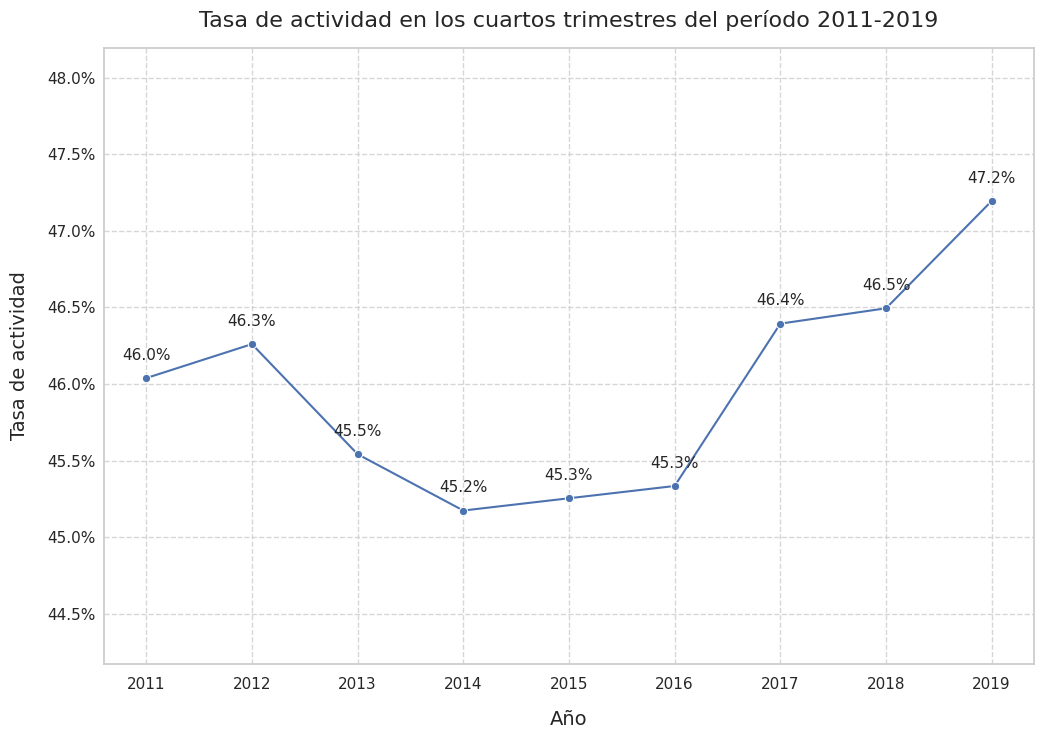

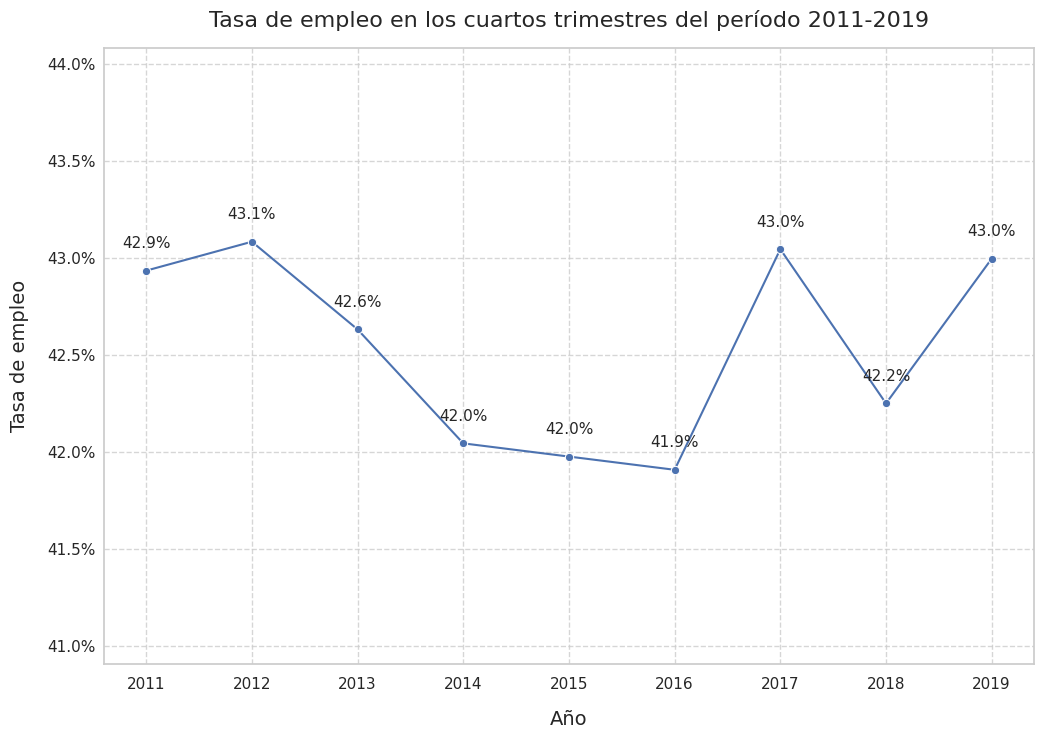

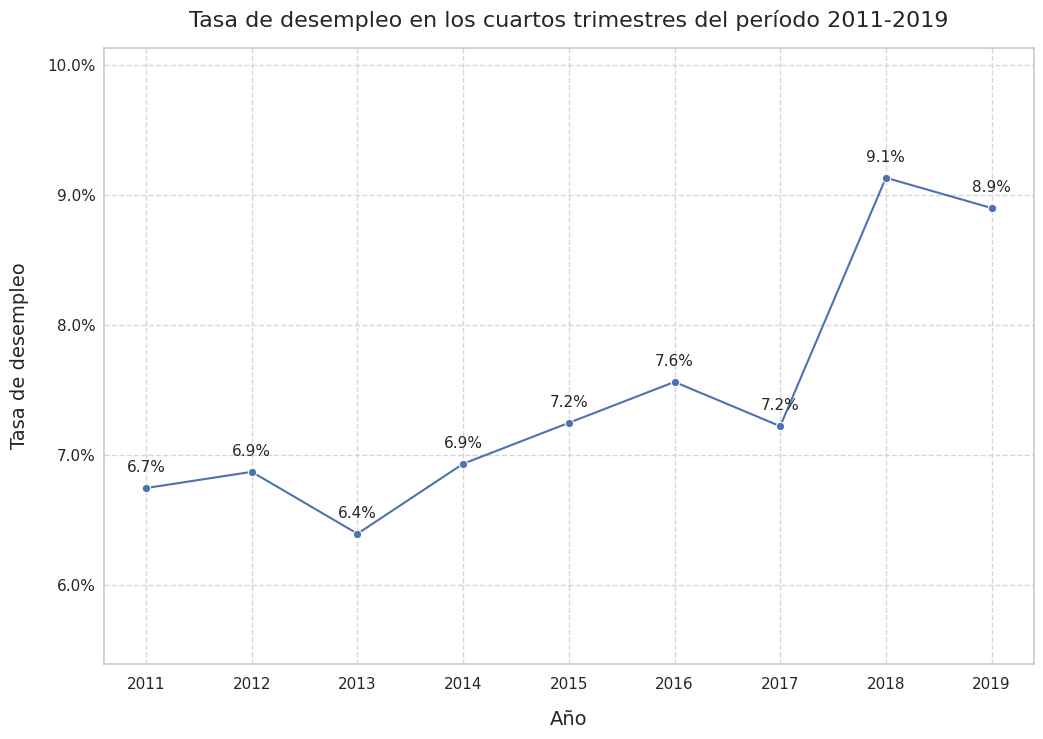

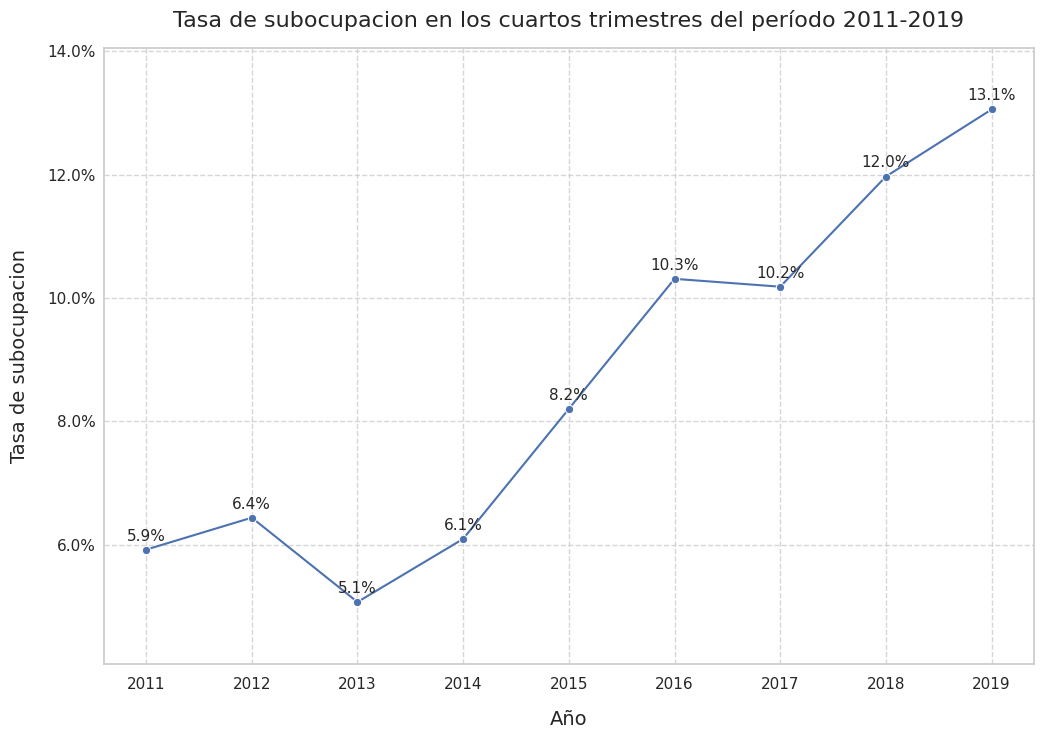

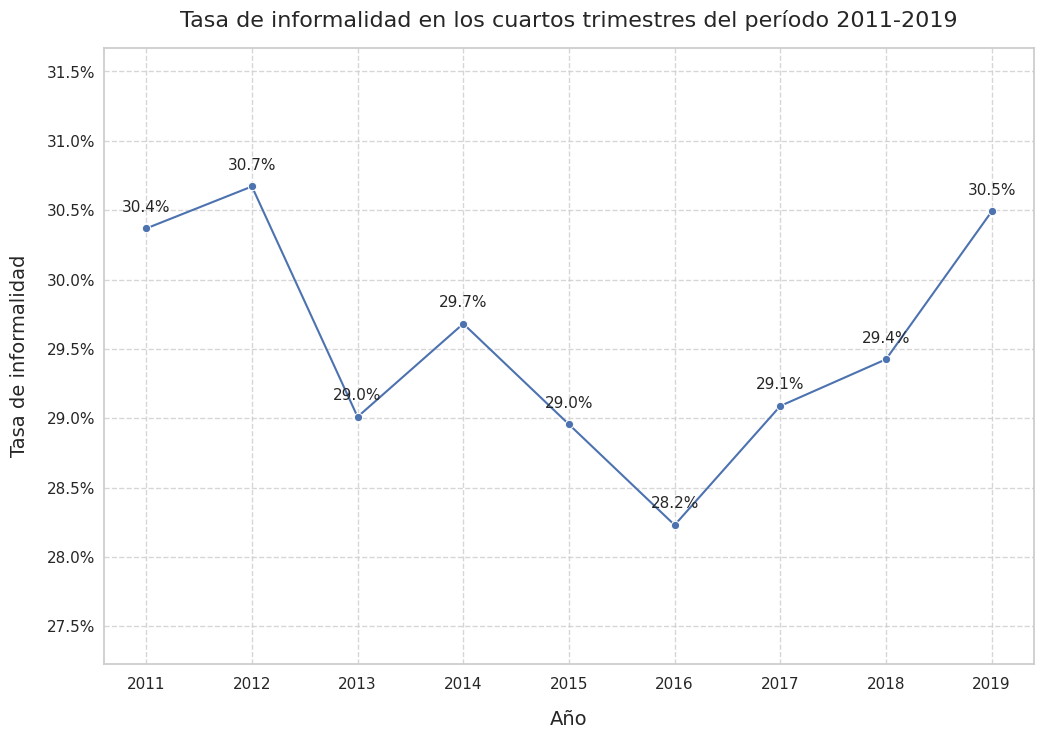

In [9]:
for tasa in tasas:
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 8))
    ax = sns.lineplot(x=años, y=tasa, data=eph, marker='o')
    plt.title(f'Tasa de {
              tasa.name.lower()} en los cuartos trimestres del período 2011-2019', fontsize=16, pad=15)
    plt.grid(True, linestyle='--', alpha=0.8)

    ax.set_xlabel('Año', fontsize=14, labelpad=13)
    ax.set_ylabel(f'Tasa de {tasa.name.lower()}', fontsize=14, labelpad=13)
    ax.set_ylim(min(tasa) - 1, max(tasa) + 1)

    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}%'))
    ax.yaxis.set_tick_params(pad=0.05)

    for x, y in zip(años, tasa):
        ax.text(x, y + 0.1, f'{y:.1f}%', ha='center', va='bottom', fontsize=11)

    plt.savefig(f"../plots/eph/general/{tasa.name}_general.png")
    plt.show()

### Por sexo

#### Cargar datos y crear carpeta

In [10]:
file_path = "../data/eph/Sexo_concatenado_interp.csv"

sexo = pd.read_csv(file_path)
sexo["Año"] = pd.to_datetime(sexo["Año"], format="%Y")

varon = sexo[sexo["Sexo"] == "Varón"].copy()
mujer = sexo[sexo["Sexo"] == "Mujer"].copy()

columnas = list(sexo.columns[2:-1])
nombre_columnas = ["Actividad", "Empleo",
                   "Desempleo", "Informalidad", "Subocupación"]
nombre_columnas = dict(zip(columnas, nombre_columnas))

os.makedirs("../plots/eph/sexo", exist_ok=True)

#### Gráficos de cada tasa por año y sexo

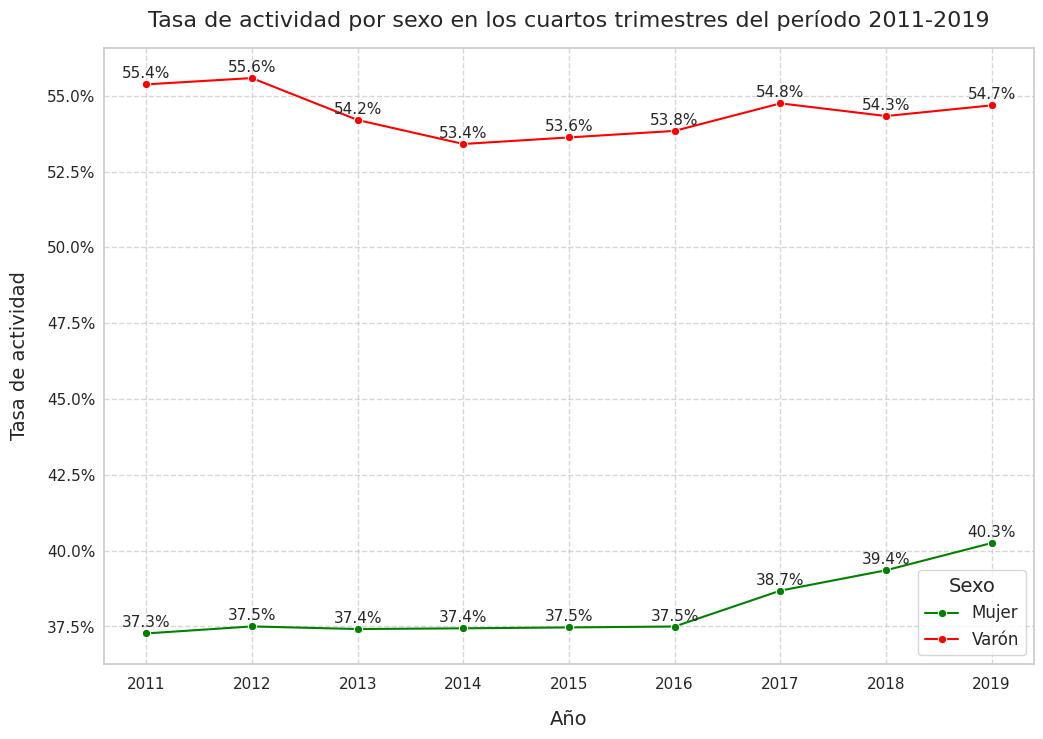

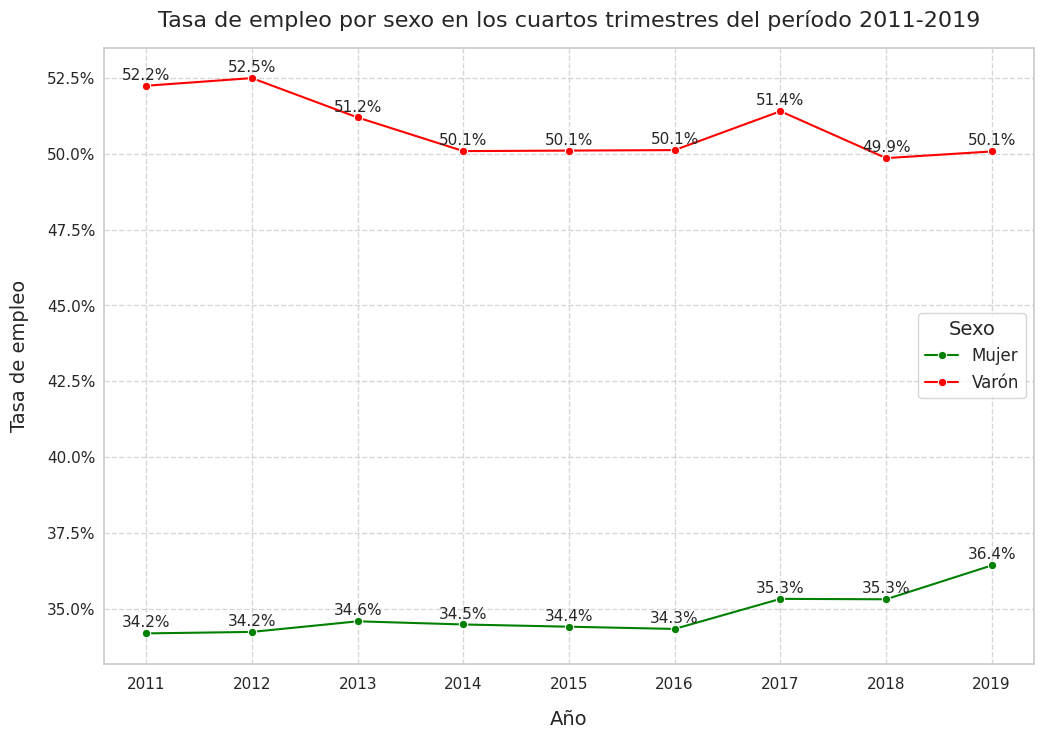

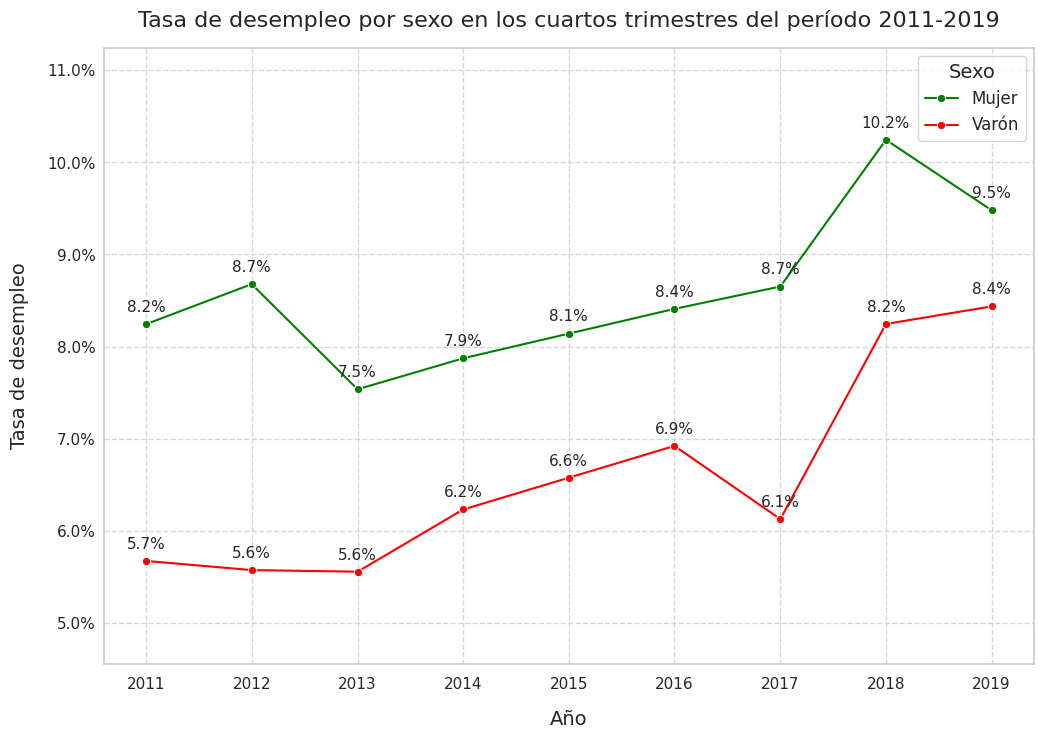

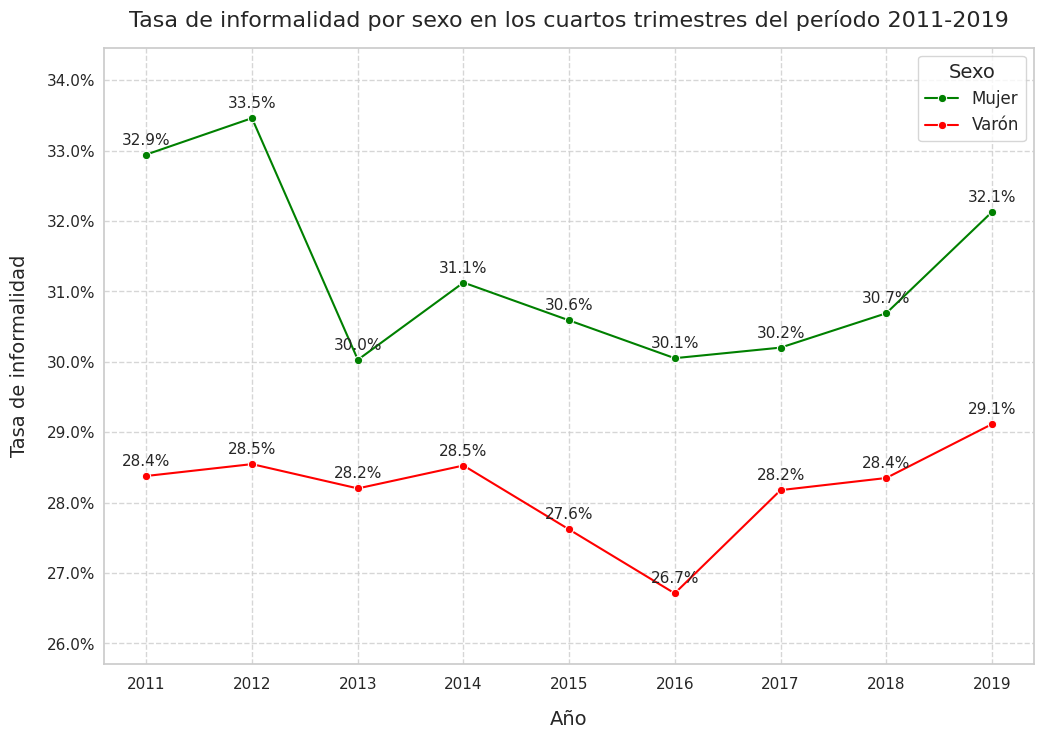

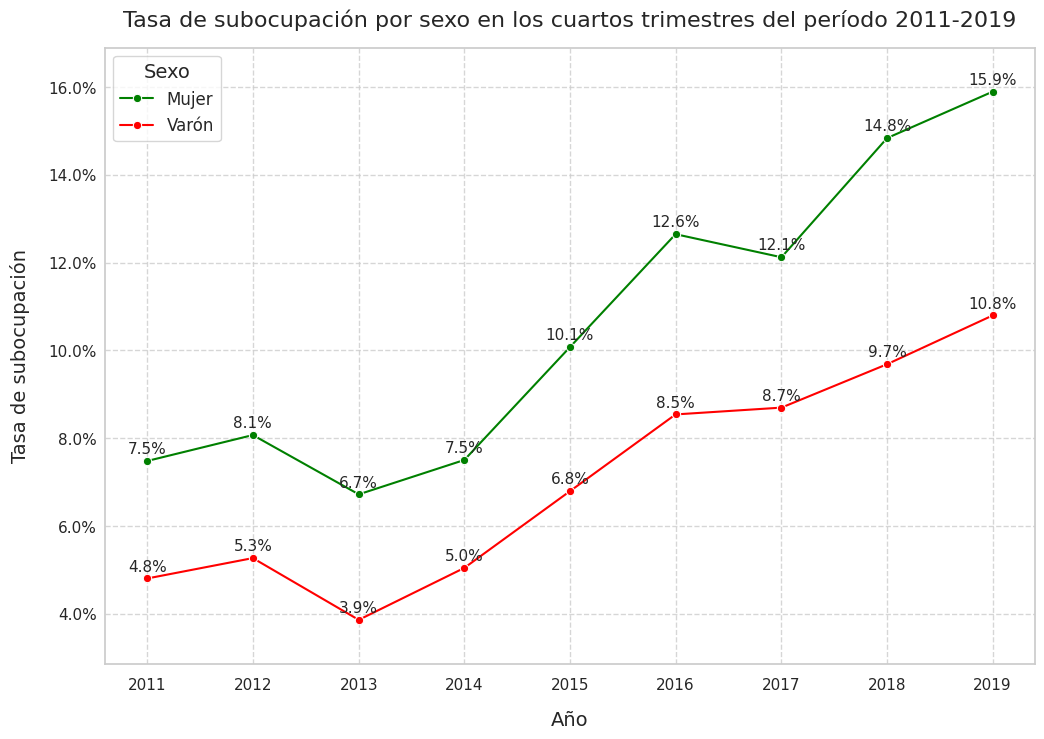

In [11]:
for columna in columnas:
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 8))
    ax = sns.lineplot(x="Año", y=columna, hue="Sexo", data=sexo,
                      marker='o', palette={"Varón": "red", "Mujer": "green"})
    plt.title(f'Tasa de {nombre_columnas[columna].lower(
    )} por sexo en los cuartos trimestres del período 2011-2019', fontsize=16, pad=15)
    plt.grid(True, linestyle='--', alpha=0.8)

    ax.set_xlabel('Año', fontsize=14, labelpad=13)
    ax.set_ylabel(f'Tasa de {nombre_columnas[columna].lower()}', fontsize=14, labelpad=13)
    ax.set_ylim(min(sexo[f'{columna}']) - 1, max(sexo[f'{columna}']) + 1)

    ax.legend(title="Sexo", title_fontsize='14', fontsize='12')

    for x, y in zip(varon["Año"], varon[columna]):
        ax.text(x, y + 0.1, f'{y:.1f}%', ha='center', va='bottom', fontsize=11)

    for x, y in zip(mujer["Año"], mujer[columna]):
        ax.text(x, y + 0.1, f'{y:.1f}%', ha='center', va='bottom', fontsize=11)

    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}%'))
    ax.yaxis.set_tick_params(pad=0.05)

    plt.savefig(f"../plots/eph/sexo/{nombre_columnas[columna]}_sexo.png")

### Por región

#### Cargar datos y crear carpeta

In [12]:
file_path = "../data/eph/Region_concatenado_interp.csv"
reg = pd.read_csv(file_path)
reg["Año"] = pd.to_datetime(reg["Año"], format="%Y")

DFs = {}
regiones = reg["REGION"].unique()
for region in regiones:
    region_df = reg[reg["REGION"] == region].copy()
    region_df["Año"] = pd.to_datetime(region_df["Año"], format="%Y")
    DFs[region] = region_df

columnas = list(reg.columns[2:-1])
nombre_columnas = ["Actividad", "Empleo",
                   "Desempleo", "Informalidad", "Subocupación"]
nombre_columnas = dict(zip(columnas, nombre_columnas))

os.makedirs("../plots/eph/region", exist_ok=True)

#### Gráficos de cada tasa por año y regíon

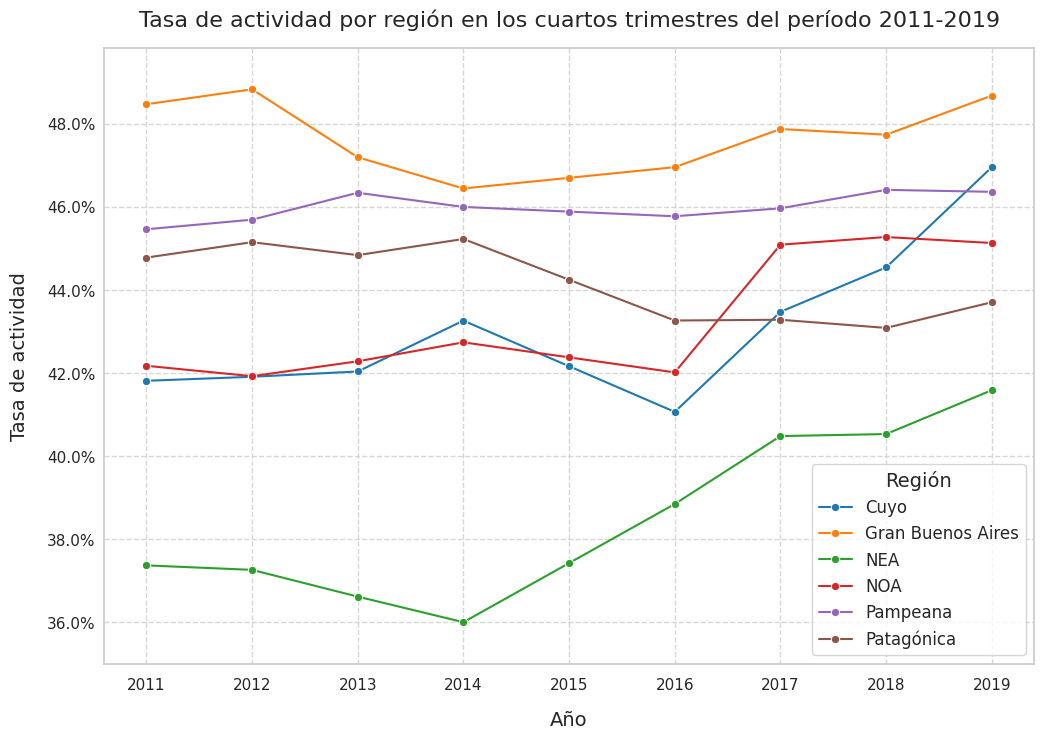

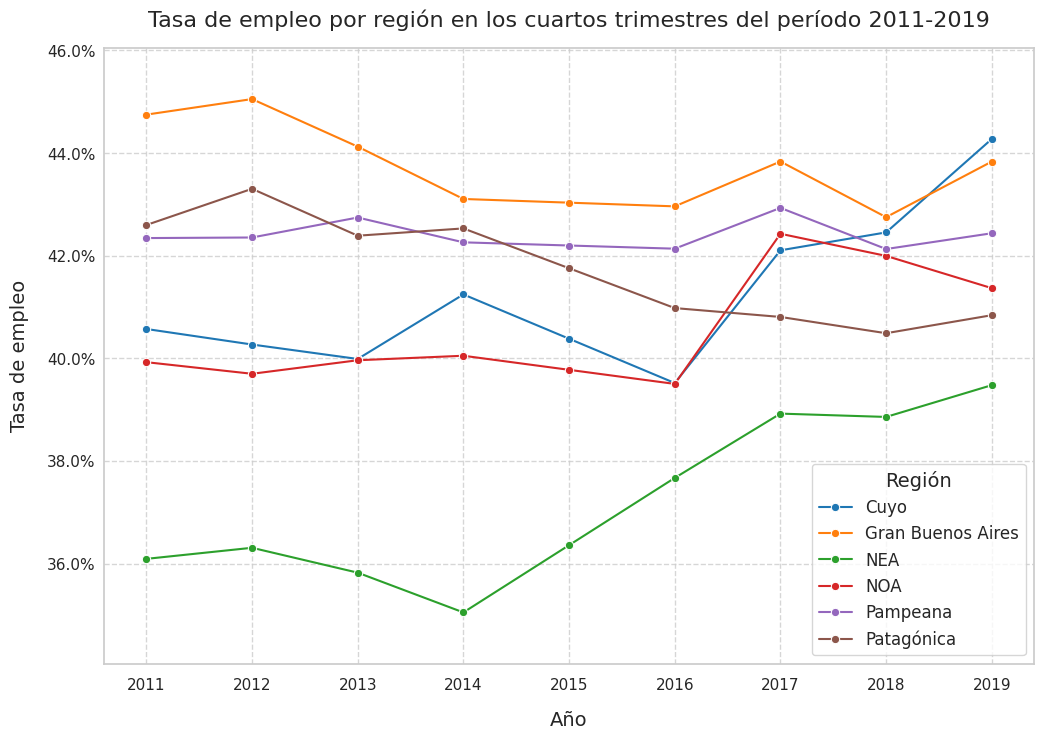

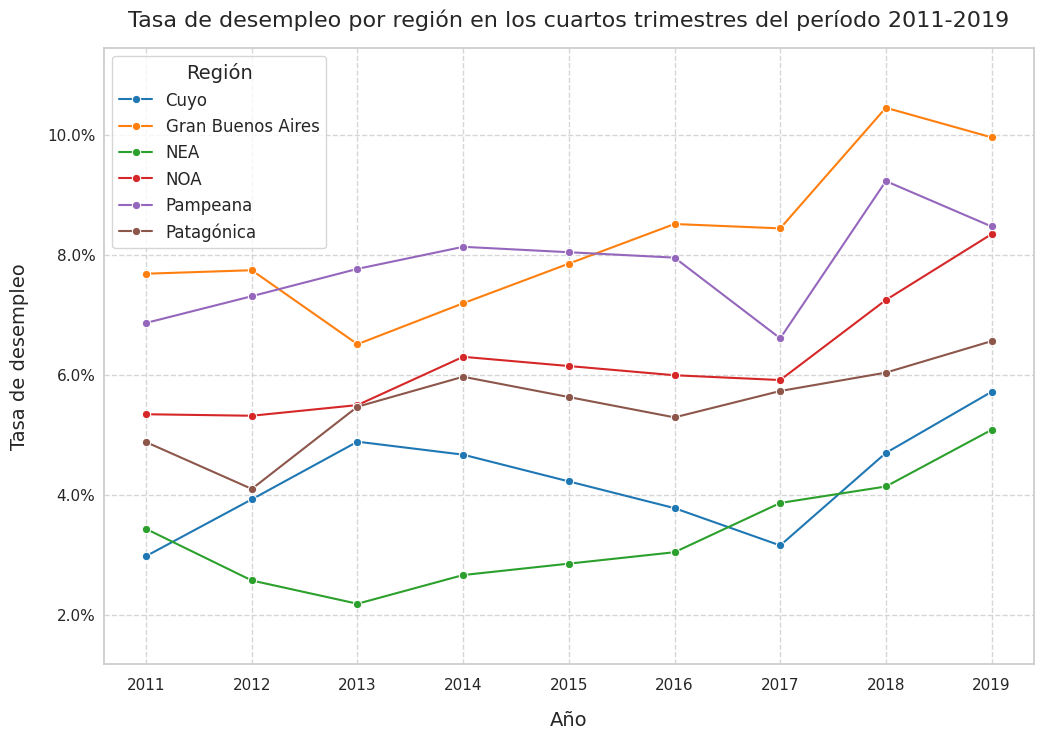

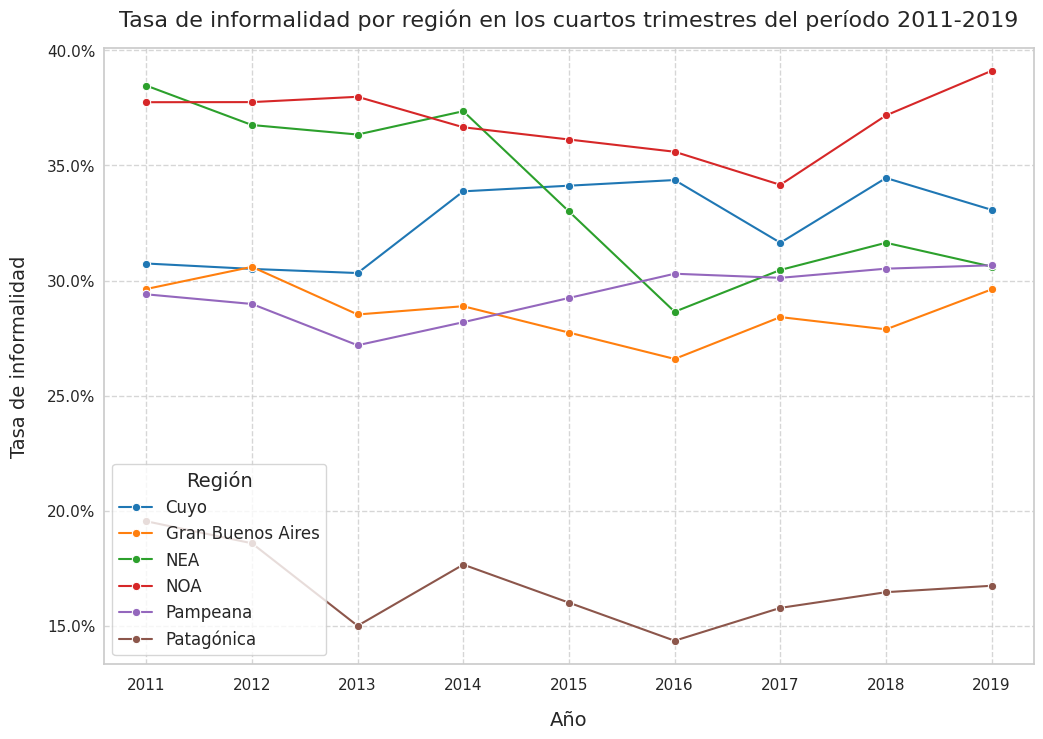

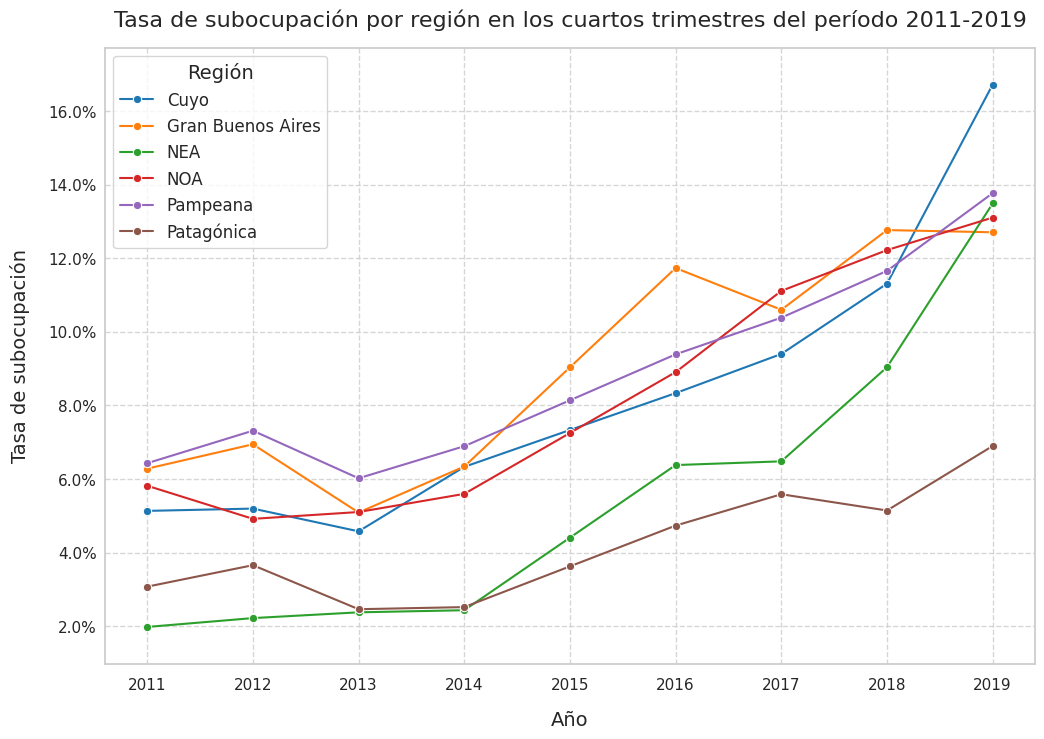

In [13]:
for columna in columnas:
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 8))
    ax = sns.lineplot(x="Año", y=columna, hue="REGION", data=reg_interp,
                      marker='o', palette=sns.color_palette("tab10", len(regiones)))
    plt.title(f"Tasa de {nombre_columnas[columna].lower(
    )} por región en los cuartos trimestres del período 2011-2019", fontsize=16, pad=15)
    plt.grid(True, linestyle='--', alpha=0.8)

    ax.set_xlabel('Año', fontsize=14, labelpad=13)
    ax.set_ylabel(f'Tasa de {nombre_columnas[columna].lower()}', fontsize=14, labelpad=13)
    ax.set_ylim(min(reg_interp[f'{columna}']) - 1,
                max(reg_interp[f'{columna}']) + 1)

    ax.legend(title="Región", title_fontsize='14', fontsize='12')

    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}%'))
    ax.yaxis.set_tick_params(pad=0.05)

    plt.savefig(f"../plots/eph/region/{nombre_columnas[columna]}_region.png")
    plt.show()